## Master degree in Computer Engineering (Ai & Robotics)

**Stella Francesco 2124359** \
**Lavezzi Luca 2154256**

# Information to Run the Code
To run the code, you need to create two folders: data_test_gemma and data100_train_ds, which will store the output results of the methods.
Also, note that at the end of the notebook, we provide a classification report and a confusion matrix based on the data obtained during testing.

# Named Entity Recognition (NER)

In this notebook we address the task of Named-Entity Recognition (NER), which consists in identifying and classifying entities such as persons, organizations, locations, and miscellaneous names within text. NER is a fundamental problem in Natural Language Processing (NLP), with applications ranging from information extraction to question answering.

For our experiments, we use the widely adopted CoNLL-2003 dataset, which contains annotated newswire articles with four types of named entities: persons, organizations, locations, and miscellaneous. This dataset is a standard benchmark for evaluating NER systems in the general domain.

To explore zero(few)-shot NER, we experiment with two instruction-tuned large language models (LLMs): **Gemma 3-27b-it**, which is accessed via API, and **DeepSeek-R1:14b**, which is executed locally using the Ollama framework.

Following the guidelines of the project, we implement and evaluate the baseline method from Xie et al. (2023), as well as one additional zero-shot prompting strategy inspired by their work. We refine our prompts and methods using a training split of the dataset, and report results on a separate test split, following best practices for NER evaluation.

The notebook is organized as follows:

- Introduction of the dataset and domain
- Documentation of any additional annotation or external libraries used
- Introduction to the models used
- Description of each zero(few)-shot method
- Evaluation and critical discussion of the results

# CoNLL 2003 Dataset

For this project, we used the CoNLL-2003 shared task dataset on language-independent named entity recognition (NER). This dataset includes annotated data for two languages, German and English, but we exclusively used the English portion for training and testing.

The English data is sourced from the Reuters Corpus, comprising newswire articles published between August 1996 and August 1997. Specifically, the training set consists of articles from a ten-day period toward the end of August 1996, while the test set includes articles from December 1996.

Each token in the dataset is annotated with one of the following four named entity types:

* PER – Person
* ORG – Organization
* LOC – Location
* MISC – Miscellaneous entities not covered by the other categories
* O – Outside of a named entity

The CoNLL-2003 dataset is widely regarded as a benchmark for evaluating NER systems due to its standardized format, high-quality annotations, and well-defined evaluation protocol (typically based on precision, recall, and F1-score). It continues to serve as a critical resource for comparing both traditional machine learning and modern deep learning approaches in sequence labeling tasks.

Using the Hugging Face Datasets library, we imported the dataset in JSON format, where each instance contains the following fields:

* id – The identifier of the sample
* tokens – A list containing the tokenized sentence
* pos_tags – A list of part-of-speech (POS) tags associated with each token
* chunk_tags – A list of syntactic chunk tags
* ner_tags – A list of named entity recognition tags corresponding to the tokens

In [ ]:
from datasets import load_dataset
import random

# Set the random seed for reproducibility
random.seed(0)
# Load the dataset
dataset = load_dataset("eriktks/conll2003")

# Access the train, validation, and test splits
train_data = dataset["train"]
validation_data = dataset["validation"]
test_data = dataset["test"]

# Sample
print("Example:", train_data[0])
print("\nTraining set size:", len(train_data))
print("Validation set size:", len(validation_data))
print("Test set size:", len(test_data))

For both the training and testing phases, we used seed 0 to ensure reproducibility, and the samples were taken from the training and test splits provided by the dataset.

# Libraries
## Google library
The Google Gen AI Python SDK provides an interface for integrating Google's generative models into Python applications. We used this library because we tested our prompts using Gemma 3. The SDK offers access to a variety of large language models from Google, through a user-friendly structure and flexible configuration options. It supports features such as adjusting the temperature for response creativity and sending batch requests for more efficient processing.

## Hugging Face
Hugging Face is a leading machine learning and data science platform and community that enables users to build, train, and deploy machine learning models with ease. It offers a wide range of pretrained large language models (LLMs) that can be used for tasks such as text generation, summarization, translation, classification, and more.

Developers can also fine-tune these models on custom datasets or even build new models from scratch using the tools provided by Hugging Face. A key component of the platform is the Transformers library, which we used in this project. It provides seamless integration with popular deep learning frameworks like PyTorch and TensorFlow, making it easier to experiment and scale models across different environments.

In addition to models, Hugging Face hosts datasets such as CoNLL2003.

## SeqEval
Seqeval is a Python library designed for evaluating sequence labeling tasks, such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking. It provides a simple and efficient way to compute standard evaluation metrics, including precision, recall, and F1-score, specifically tailored for structured prediction tasks where labels follow formats like IOB/IOB2. We adopt this library to evaluate our results and compare the various methods.

## Ollama
The ollama library provides a Python interface to interact with large language models (LLMs) running locally via the Ollama server. It allows users to send prompts, receive model-generated responses, and manage inference workflows directly from Python code. This makes it easy to integrate advanced generative AI capabilities into data analysis pipelines, research experiments, or application development, all while keeping computation on the local machine.

## SpaCy
The SpaCy library is an open-source software library for advanced natural language processing (NLP), written in Python and Cython. Unlike libraries such as NLTK, which are often used for teaching and research, spaCy is designed specifically for production use, offering fast and robust tools for tasks like tokenization, part-of-speech tagging, dependency parsing, text categorization, and named entity recognition (NER).

spaCy supports deep learning workflows and can integrate with popular machine learning libraries such as TensorFlow and PyTorch via its own backend, Thinc. It provides prebuilt neural network models for 23 languages and supports tokenization for over 65 languages, making it suitable for both multilingual applications and custom model training.


In [11]:
%pip install -q -U google-genai
%pip install seqeval
%pip install google-generativeai
%pip install ipywidgets --upgrade
%pip install transformers
%pip install pydantic
%pip install datasets[all]
%pip install pandas
%pip install ollama
%pip install spacy
%pip install seaborn
%python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


   ---------------------------------------- 0.0/139.8 kB ? eta -:--:--
   ---------------------------------------- 139.8/139.8 kB ? eta 0:00:00
   ---------------------------------------- 0.0/216.6 kB ? eta -:--:--
   --------------------------------------- 216.6/216.6 kB 13.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 70.5 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 4.0.10
    Uninstalling widgetsnbextension-4.0.10:
      Successfully uninstalled widgetsnbextension-4.0.10
  Attempting uninstall: jupyterlab_widgets
    Found existing installation: jupyterlab-widgets 3.0.10
    Uninstalling jupyterlab-widgets-3.0.10:
      Successfully uninstalled jupyterlab-widgets-3.0.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 8.1.2
    Uninstalling ipywidgets-8.1.2:
      Successfully uninstalled ip

  Using cached regex-2024.11.6-cp312-cp312-win_amd64.whl.metadata (41 kB)
  Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
   --------- ------------------------------ 2.7/10.8 MB 83.2 MB/s eta 0:00:01
   ---------------------- ----------------- 6.1/10.8 MB 77.9 MB/s eta 0:00:01
   ---------------------- ----------------- 6.1/10.8 MB 55.4 MB/s eta 0:00:01
   ------------------------ --------------- 6.5/10.8 MB 37.9 MB/s eta 0:00:01
   --------------------------- ------------ 7.5/10.8 MB 34.4 MB/s eta 0:00:01
   ---------------------------------------  10.8/10.8 MB 40.9 MB/s eta 0:00:01
   ---------------------------------------- 10.8/10.8 MB 34.4 MB/s eta 0:00:00
Using cached regex-2024.11.6-cp312-cp312-win_amd64.whl (273 kB)
Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl (308 kB)
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 294.9/294.9 kB 9.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


# Models

For the development and evaluation of the prompts in this project, we used two different large language models: Gemma 3 (27B) and DeepSeek.

## Gemma 3 (27b)

We chose Gemma 3 because it is a recently released model by Google, offering several notable advantages:

* Computational efficiency: Gemma 3 is a relatively lightweight model that achieves reasonable performance compared to state-of-the-art (SOTA) models like Gemini 2.5 Pro, which has over ten times more parameters.
* API limits: Unlike many other models with free-tier APIs, Gemma 3 allows for a higher number of requests per day, making it more suitable for iterative development and testing.

However, these advantages come with a significant trade-off:

* Lower performance: In our tests, Gemma 3 underperformed compared to more advanced models. When evaluated against Gemini 2.0 Flash, we observed a performance gap of up to 20% in F1-score. Despite this, using higher-performing models was impractical due to API rate limitations, which would have required a considerable amount of additonal time to complete equivalent testing. 

The lower accuracy of Gemma 3 also influenced our implementation: model outputs required additional validation and post-processing. In some cases, responses did not adhere to the expected output format, necessitating extra checks and error handling in our code.

## DeepSeek-R1 (distilled)
In this section, we show and discuss our implementation on the DeepSeek-R1 model (distilled).

### How to run DeepSeek-R1 locally
Go to https://ollama.com, download and install ollama.
Then, search for DeepSeek-R1's available models: https://ollama.com/library/deepseek-r1.
Click on a model you wish to download and copy the command to run in the terminal (for instance: ollama run deepseek-r1:14b).


### Model selection
Our choice for the model was based on two factors: time consumption and performance.
We decided to use `deepseek-r1:14b` because it generated tokens relatively fast while still performing almost as good as gemma-3-27b-it, a model we used previously which had acceptable performance.
Trying to run bigger models such as deepseek-r1:32b was not feasible due to the very long token generation times.
The increase in performance compared to deepseek-r1:14b was also very minimal, which led us to try even smaller models, such as deepseek-r1:7b and deepseek-r1:8b, which performed much worse instead.



# **Implemented methods (DeepSeek)**
In this section, we list and describe the methods we implemented using deepseek-r1:14b. Each prompt corresponds to a specific approach, and the results for each method are saved in a CSV file identified by the method's acronym.

## - Word-level named entity reflection (WLNER)

In this method, we add to the vanilla prompt another instruction which asks the model to generate a short summary for each word in the sentence. The summary had to be very short (around ten words) and is supposed to give an explanation, motivating the reason why a certain word can or cannot be a potential candidate to be classified as a NER tag.

This approach explicitly leverages the **chain of thought** capability of large language models: by prompting the model to reflect and reason about each token individually, it is encouraged to articulate its decision-making process step by step. This not only helps the model to make more informed tagging decisions, but also provides interpretability, as the generated summaries reveal the rationale behind each prediction.

However, this method performed slightly worse compared to the baseline reported in the reference paper.

>This method was designed and developed by us specifically for this project.

## - Multi-turn adaptive refinement (MTAR)

In this method we asked the model to name the potential candidate words to be classified as NER tags. The model had to give an explanation for every word it believed to be a candidate NER tag, and then give the results in the correct format.

Similarly to the previously mentioned method, this approach explicitly leverages the **chain of thought** capabilities of large language models. By prompting the model to reason step by step about which words are likely entities and to justify its choices, we encourage a more structured and interpretable decision-making process. This not only helps the model focus on the most relevant tokens, but also reduces the overall size of the output text generated, since the prompt specifies to just list the candidate NER tags and their explanations.

This method performed slightly better compared to the baseline counterpart.

>This method was designed and developed by us specifically for this project.

## - Dependency-based entity validation (DBEV)
In this method we added the dependency tree in the prompt, obtained by using spaCy (the dependency tree was not part of the dataset).

The motivation behind this approach was to provide the model with additional syntactic information about the relationships between words in the sentence. By including the dependency tree, the model could potentially leverage the grammatical structure to better identify entities, especially in complex sentences where context and word dependencies play a crucial role.

To implement this, we used spaCy to generate the dependency tree for each sentence, representing the syntactic relations in a structured format. This tree was then inserted into the prompt alongside the tokens to be tagged. The expectation was that the model, with access to this extra layer of linguistic information, would be able to make more informed tagging decisions, particularly in cases where surface-level cues were insufficient.

However, in our experiments, we observed that the F1 score associated to this method was slightly worse.

It is also important to note that the dependency trees were not originally part of the dataset and had to be computed using spaCy. This introduces a potential source of error, as the quality of the dependency parsing depends on the accuracy of spaCy's model. If the dataset had included gold-standard dependency trees, or if the dependency information had been annotated and curated specifically for the NER task, the results could have been better and the model might have been able to exploit this information more effectively.

>This method was already used in the reference paper.

## - POS-guided named entity recognition (POSGNER)
In this method we added the POS tags for every token of the sentence, which are part of the dataset.

The main idea behind this approach is to provide the model with explicit information about the grammatical role of each token in the sentence. Part-of-speech (POS) tags indicate whether a word is a noun, verb, adjective, proper noun, etc., and can be very helpful for named entity recognition because certain entity types are strongly associated with specific POS tags (for example, proper nouns are often persons, organizations, or locations).

By including the POS tags in the prompt, we aimed to help the model disambiguate cases where the token alone might not be sufficient to determine the correct entity type. For instance, the word "Apple" could refer to a fruit (common noun) or a company (proper noun), and the POS tag can provide a useful clue for the model to make the right choice.

In practice, we formatted the prompt so that the model received both the list of tokens and the corresponding POS tags in order. This additional information allowed the model to make more informed predictions, especially in sentences with ambiguous or rare words. Our experiments showed that this method generally improved the F1 score compared to the vanilla approach, confirming the usefulness of syntactic information for NER tasks.

The performance scores indicate that this method was better than the baseline method implemented in the reference paper.

>This method was already used in the reference paper.

## - POS-dependency hybrid NER (POSDHNER)
In this method we added to the prompt both the POS tags and the dependency tree.

The rationale behind this approach is to combine two complementary sources of linguistic information: the part-of-speech (POS) tags, which indicate the grammatical role of each token, and the dependency tree, which describes the syntactic relationships between words in the sentence. By providing both types of annotations, we aimed to give the model a richer context for making NER predictions, especially in cases where either POS or dependency information alone might not be sufficient.

In practice, the prompt was structured to include the list of tokens, their corresponding POS tags, and the full dependency tree (as computed by spaCy) for each sentence. This allowed the model to consider not only the type of each word but also how words are connected and which tokens are likely to form multi-word entities based on their syntactic structure.

However, our experiments showed that the performance was close to the dependency-based entity validation method. Additionally, as with the dependency-based method, the quality of the dependency tree depends on the accuracy of spaCy's parser. If gold-standard dependency annotations had been available in the dataset, the results might have been better and the model could have leveraged this information more effectively.

>This method was designed and developed by us specifically for this project.

## - Example-driven POS NER (EDPOSNER)
In this method we added the POS tags for every token of the sentence. We also added three complete examples, which consisted of the sentence tokens, POS tags and NER tags associated to such tokens. Thus this can be considered as a **few-shot learning** method.

The main motivation for this approach was to provide the model with concrete, context-rich demonstrations of the NER task, making it easier for the model to generalize the tagging strategy to new sentences. By including three full examples in the prompt—each showing the tokens, their corresponding POS tags, and the correct NER tags—the model could observe how the tagging should be performed in practice, even for more complex or ambiguous cases.

In our experiments, this method generally led to similar performance compared to the original prompt without examples.

>This method was designed and developed by us specifically for this project.

# Implemented Methods (Gemma)

## - POS NER with Viterbi Algorithm (POSVITNER)
To compute POS tags, we experimented with prompting the model to use the Viterbi algorithm in conjunction with the English-specific Penn Treebank (PTB) tagset. The prompt included a complete list of BIO tags for the entity classes and enforced strict rules for the output format.

We explored this approach to apply concepts covered during lectures. The underlying hypothesis was that requiring the model to first infer the POS tags would force it to reason more deeply about the syntactic structure of the sentence before performing NER. This additional layer of analysis was expected to improve overall tagging performance.

Results showed the opposite: the method introduced significant computational overhead, and the performance was substantially worse compared to both the vanilla and best-performing approaches.

>This method was designed and developed by us specifically for this project.

In addition, also Example-Driven POS NER and POS-guided NER methods were implemented for Gemma, with small differences that did not change the overall results.

### Evaluation Without BIO Tag Distinction

In addition to the standard evaluation using the full BIO tagging scheme (where each entity is labeled as either Beginning (B), Inside (I), or Outside (O)), we also conducted experiments by removing the distinction between B- and I- tags. In this alternative evaluation, entity types are considered without regard to whether a token is at the beginning or inside of an entity span. For example, both `B-PER` and `I-PER` are mapped to a single `PER` category.

This approach allows us to consider a prediction as correct even if the model predicts a `B` tag instead of an `I` tag (or vice versa), as long as the entity type itself is correct. The motivation behind this evaluation is to focus on the model's ability to recognize the correct entity type, regardless of its position within the entity span. This can be particularly useful for assessing the robustness of the model in scenarios where the precise span boundaries are less critical than the correct identification of entity types.

To implement this, we mapped all `B-` and `I-` tags of the same entity type to a single label. The evaluation metrics were then computed on these simplified labels, providing an additional perspective on the model's performance.

The csvs obtained by ignoring the BIO tagging end with **NOBIO**

### Model's response parsers

Here we list the functions for parsing and storing the model's response.

In [3]:
import csv
import os

def parse_response(tokens : list, response_labels : list, true_labels : list) -> list: 
    '''
    Store the response in a list of lists where the first element is the token, the second element 
    is the predicted label and the third is the true label
    '''
    response_labels = response_labels.split(":")
    response_labels = response_labels[1].strip('\n').split(',')
    if (len(response_labels) != len(tokens)):
        if (len(response_labels) > len(tokens)):
            response_labels = response_labels[:len(tokens)]
        if (len(response_labels) < len(tokens)):
            response_labels = response_labels + ['0'] * (len(tokens) - len(response_labels))

    temp = []
    for i in range(len(tokens)):
        pred_label = int(response_labels[i].strip())
        if(pred_label < 0 or pred_label > 8):
            print(f"Token: {tokens[i]}, Predicted Label: {pred_label}, True Label: {true_labels[i]}")
        temp.append([tokens[i], pred_label, true_labels[i]])

    return temp

def save_to_csv_vanilla(tokens : list, pred_labels : list, true_labels : list, filename : str) -> None:
    file_exists = os.path.isfile(filename)
    # Write header only if the file didn't exist before
    if not file_exists:
        with open(filename, 'a', newline='') as csvfile:
            header = ['token', 'pred', 'true']
            writer = csv.writer(csvfile)
            writer.writerow(header)
    if (len(pred_labels) == 0 and len(true_labels) == 0):
        return
    data = [[tokens[i], pred_labels[i], true_labels[i]] for i in range(len(tokens)) if pred_labels[i] != 0 or true_labels[i] != 0]
    # Remove duplicates
    # Open the file in append mode and write data to analysis purpose
    with open(filename, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(data)
        
        
        

begin_tags = {1,3,5,7}

def parse_response_no_bio(tokens : list, response_labels : list, true_labels : list) -> list: 
    '''
    Store the response in a list of lists where the first element is the token, the second element 
    is the predicted label and the third is the true label
    '''
    response_labels = response_labels.split(":")
    response_labels = response_labels[1].strip('\n').split(',')
    if (len(response_labels) != len(tokens)):
        if (len(response_labels) > len(tokens)):
            response_labels = response_labels[:len(tokens)]
        if (len(response_labels) < len(tokens)):
            response_labels = response_labels + ['0'] * (len(tokens) - len(response_labels))

    temp = []
    for i in range(len(tokens)):
        if i > 0 and temp[i-1][1] in begin_tags and int(response_labels[i].strip()) in begin_tags:
            # If the previous token is a begin tag and this is not '0', we assume it's a continuation
            pred_label = int(response_labels[i].strip()) + 1
        elif i > 0 and int(response_labels[i].strip()) in begin_tags and (temp[i-1][1] - 1) == int(response_labels[i].strip()):
            # if previous token is an inside token and the current is in the same category, we assume it's a continuation
            pred_label = int(response_labels[i].strip()) + 1
        else:
            # Otherwise, we take the label as is
            pred_label = int(response_labels[i].strip())
        if(pred_label < 0 or pred_label > 8):
            print(f"Token: {tokens[i]}, Predicted Label: {pred_label}, True Label: {true_labels[i]}")
        #assert (pred_label >= 0 and pred_label <= 8), "Predicted label is out of range"
        temp.append([tokens[i], pred_label, true_labels[i]])

    return temp

### Training data sampling

Here we sample the first 100 sentences from the training set using a fixed seed.

In [ ]:
import random

random.seed(0)

# Sample 100 random elements from the test set
sampled_test_data = random.sample(list(test_data), 100)

# Print the first few samples to verify
for i, sample in enumerate(sampled_test_data[:5]):  # Display the first 5 samples
    print(f"Sample {i + 1}:")
    print(sample)
    print("\n")

### Dependency tree computation

Here we report the code for computing the dependency trees for the training data usign spaCy.

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

dependency_trees = []

for sample in sampled_test_data:
    tokens = sample["tokens"]
    sentence = " ".join(tokens)
    doc = nlp(sentence)
    tree = [
        {
            "text": token.text,
            "dep": token.dep_,
            "head": token.head.text,
            "pos": token.pos_,
            "index": token.i,
            "head_index": token.head.i
        }
        for token in doc
    ]
    dependency_trees.append(tree)

# Link the two lists
for i, sample in enumerate(sampled_test_data):
    sample['dependency_tree'] = dependency_trees[i]

# Now each sample has the tree inside
print(sampled_test_data[0]['dependency_tree'])


### Clean response function

This function is used to format properly the response coming from a deepseek model.

In [6]:
import re
import os
import csv
import json
from datasets import load_dataset
from ollama import Client


def clean_response(text):
    """Cleans the model's output to extract only the numbers."""
    # Remove <think>...</think> blocks
    cleaned = re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL).strip()

    # Look for the pattern 'ner_tags: 0, 1, 2, ...'
    match = re.search(r'ner_tags\s*:\s*([0-9,\s]+)', cleaned)
    if match:
        number_str = match.group(1)
    else:
        # If 'ner_tags:' is not found, but there are still numbers, extract them all
        number_str = cleaned

    # Extract all integers as strings
    number_list = re.findall(r'\d+', number_str)
    return number_list



### Format example function

This function is used for the few-shot prompts, giving them a formatted example.

In [7]:
def format_example(ex):
    return f"""Tokens: {ex['tokens']}
POS tags: {ex['pos_tags']}
NER tags: {ex['ner_tags']}"""

# Using 3 random examples in the prompt (different from the ones used in the training)
example1 = train_data[11000]
example2 = train_data[12000]
example3 = train_data[13000]

## POS-guided named entity recognition

Here we report the best prompt found using deepseek-r1:14b and the code used to generate the responses.

In [ ]:
# DEEPSEEK
# Initialize client
client = Client()

for j in range(len(sampled_test_data)):
    tokens = sampled_test_data[j]['tokens']
    pos_tags = sampled_test_data[j]['pos_tags']
    true_labels = sampled_test_data[j]['ner_tags']
    dependency_tree = dependency_trees[j]

    # Convert dependency_tree to JSON string
    dependency_tree_str = json.dumps(dependency_tree, indent=2)

    prompt = f"""You are a strict NER tagging system.

    Given the following NER tags:
    {{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}}

    Your task is to assign the correct tag number to each token in this sentence:
    {tokens}

    You are also given the POS tag (part-of-speech) for each token.
    POS tags (in order, one per token):
    {pos_tags}

    Respond ONLY with:
    ner_tags: x, x, x, ..., x  ← (exactly {len(tokens)} integers)

    Do NOT include explanations, thoughts, or any other content.
    Do NOT write anything before or after "ner_tags: ...".
    Just print the sequence in the format specified.
    """

    try:
        response = client.generate(model="deepseek-r1:14b", prompt=prompt)
        raw_text = response.response
        pred_tags_str = clean_response(raw_text)

        # Parsing (conversion and validation)
        parsed_data = parse_response(tokens, f"ner_tags: {','.join(pred_tags_str)}", true_labels)

        # Debug print
        print(f"[✓] Sentence {j}")
        print("Tokens:    ", tokens)
        print("Predicted: ", [x[1] for x in parsed_data])
        print("True:      ", [x[2] for x in parsed_data])
        print("---")

        # Save to file
        save_to_csv_vanilla(tokens, [x[1] for x in parsed_data], true_labels, "data100_test_ds/vanilla_test_100_ds_14b_POSGNER.csv")

    except Exception as e:
        print(f"[!] Error at sentence {j}: {e}")
        print(f"Raw response: {response.response if 'response' in locals() else 'None'}")
        print("---")


In [ ]:
# GEMMA
from google import genai
import time
import os

for j in range(len(sampled_test_data)):
    # Extract tokens and true labels
    tokens = sampled_test_data[j]['tokens']
    true_labels = sampled_test_data[j]['ner_tags']
    pos_tags = sampled_test_data[j]['pos_tags']
    model = "gemma-3-27b-it"
    client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
    content = f"""You are a strict NER tagging system.

    Given the following NER tags:
    {{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}}

    Your task is to assign the correct tag number to each token in this sentence:
    {tokens}

    You are also given the POS tag (part-of-speech) for each token.
    POS tags (in order, one per token):
    {pos_tags}

    Respond ONLY with:
    ner_tags: x, x, x, ..., x  ← (exactly {len(tokens)} integers)

    Do NOT include explanations, thoughts, or any other content.
    Do NOT write anything before or after "ner_tags: ...".
    Just print the sequence in the format specified.
    """
    # Send request 
    try:
        response = client.models.generate_content(
            model=model,
            contents= content
        )
        time.sleep(1)

    except Exception as e:
        time.sleep(5)
        response = client.models.generate_content(
            model=model,
            contents=content
        )

    # Parse the response
    data = parse_response_no_bio(tokens, response.text, true_labels)

    save_to_csv_vanilla(tokens, [item[1] for item in data], true_labels, "data_test_gemma/pos_guided_bio.csv")

### Using the same model without the BIO tagging

Here we present the code used for the same prompt without using the BIO tagging.
For this instance, the F1 score obtained using the nobio format was worse compared to his regular counterpart.

In [ ]:
# DEEPSEEK
# Initialize client
client = Client()

for j in range(len(sampled_test_data)):
    tokens = sampled_test_data[j]['tokens']
    pos_tags = sampled_test_data[j]['pos_tags']
    true_labels = sampled_test_data[j]['ner_tags']
    dependency_tree = dependency_trees[j]

    # Convert dependency_tree to JSON string
    dependency_tree_str = json.dumps(dependency_tree, indent=2)

    prompt = f"""You are a strict NER tagging system.

    Given the following NER tags:
    {{'O': 0, 'B-PER': 1, 'B-ORG': 3, 'B-LOC': 5, 'B-MISC': 7}}

    Your task is to assign the correct tag number to each token in this sentence:
    {tokens}

    You are also given the POS tag (part-of-speech) for each token.
    POS tags (in order, one per token):
    {pos_tags}

    Respond ONLY with:
    ner_tags: x, x, x, ..., x  ← (exactly {len(tokens)} integers)

    Do NOT include explanations, thoughts, or any other content.
    Do NOT write anything before or after "ner_tags: ...".
    Just print the sequence in the format specified.
    """

    try:
        response = client.generate(model="deepseek-r1:14b", prompt=prompt)
        raw_text = response.response
        pred_tags_str = clean_response(raw_text)

        # Parsing (conversion and validation)
        parsed_data = parse_response_no_bio(tokens, f"ner_tags: {','.join(pred_tags_str)}", true_labels)

        # Debug print
        print(f"[✓] Sentence {j}")
        print("Tokens:    ", tokens)
        print("Predicted: ", [x[1] for x in parsed_data])
        print("True:      ", [x[2] for x in parsed_data])
        print("---")

        # Save to file
        save_to_csv_vanilla(tokens, [x[1] for x in parsed_data], true_labels, "data100_test_ds/vanilla_test_100_ds_14b_POSGNER_NOBIO.csv")

    except Exception as e:
        print(f"[!] Error at sentence {j}: {e}")
        print(f"Raw response: {response.response if 'response' in locals() else 'None'}")
        print("---")


In [ ]:
# GEMMA

for j in range(len(sampled_test_data)):
    # Extract tokens and true labels
    tokens = sampled_test_data[j]['tokens']
    true_labels = sampled_test_data[j]['ner_tags']
    pos_tags = sampled_test_data[j]['pos_tags']
    model = "gemma-3-27b-it"
    client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
    content = f"""You are a strict NER tagging system.

    Given the following NER tags:
    {{'O': 0, 'PER': 1, 'ORG': 3, 'LOC': 5, 'MISC': 7}}

    Your task is to assign the correct tag number to each token in this sentence:
    {tokens}

    You are also given the POS tag (part-of-speech) for each token.
    POS tags (in order, one per token):
    {pos_tags}

    Respond ONLY with:
    ner_tags: x, x, x, ..., x  ← (exactly {len(tokens)} integers)

    Do NOT include explanations, thoughts, or any other content.
    Do NOT write anything before or after "ner_tags: ...".
    Just print the sequence in the format specified.
    """
    # Send request 
    try:
        response = client.models.generate_content(
            model=model,
            contents= content
        )
        time.sleep(1)

    except Exception as e:
        time.sleep(5)
        response = client.models.generate_content(
            model=model,
            contents=content
        )

    # Parse the response
    data = parse_response_no_bio(tokens, response.text, true_labels)

    save_to_csv_vanilla(tokens, [item[1] for item in data], true_labels, "data_test_gemma/pos_guided_no_bio.csv")

# Context Aware No BIO tagging Named Entity Recognition

This is the prompt for Gemma3 that achieved the best performance on the training set. It does not use the BIO tagging format, as the model delivered better results without it during training. We hypothesize that omitting BIO tags reduces complexity for the model, allowing it to focus more on contextual understanding rather than token-level sequence formatting.

While experimenting with more complex methods, such as longer prompts containing additional technical details, we observed no improvement in performance. In fact, providing excessive technical information appeared to hinder the model. Instead, we found that delivering clear, concise descriptions of the semantic context for each entity class and rules led to better outcomes.

We also adopted this approach from a resource-efficiency perspective. Since Gemma3 is a relatively small model (27 billion parameters), a straightforward, tightly scoped prompt, which clearly defines the rules and includes only the essential information, requires less computation time compared to more elaborate methods like Decomposed QA, while still delivering consistent and reliable performance.

In [ ]:
#GEMMA

for j in range(len(sampled_test_data)):
    # Extract tokens and true labels
    tokens = sampled_test_data[j]['tokens']
    true_labels = sampled_test_data[j]['ner_tags']
    model = "gemma-3-27b-it"
    client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
    content = f"""You are an expert in Named Entity Recognition (NER). Your task is to assign an entity tag ID to each token in the sentence using the strict schema below.

            NER Tag IDs:
            - 0 = O → Not an entity  
            - 1 = PERSON → Real names, personal titles   
            - 3 = ORGANIZATION → Companies, institutions, teams, agencies 
            - 5 = LOCATION → Cities, countries, natural landmarks, buildings
            - 7 = MISCELLANEOUS → Nationalities, languages, events, products, titles of works 

            ---

            Rules:
            - Use only contextual evidence to determine entity types.
            - If the token does not clearly match a defined type, assign `0 (O)`.
            - Please do not assign tags based on assumptions or incomplete context.
            - Please be as precise as possible

            ---

            Now tag the sentence below:
            Sentence: {tokens}  
            This sentence contains exactly {len(tokens)} tokens.

            Your answer MUST follow this format:  
            ner_tags: 0, 1, 0, 5, 5, 0  
            (Must return exactly {len(tokens)} tag IDs in order, no extra text.)
            """
    # Send request 
    try:
        response = client.models.generate_content(
            model=model,
            contents= content
        )
        time.sleep(1)

    except Exception as e:
        time.sleep(5)
        response = client.models.generate_content(
            model=model,
            contents=content
        )

    # Parse the response
    data = parse_response_no_bio(tokens, response.text, true_labels)

    save_to_csv_vanilla(tokens, [item[1] for item in data], true_labels, "data_test_gemma/context_aware.csv")

In [ ]:
# DEEPSEEK
# Initialize client
client = Client()

for j in range(len(sampled_test_data)):
    tokens = sampled_test_data[j]['tokens']
    pos_tags = sampled_test_data[j]['pos_tags']
    true_labels = sampled_test_data[j]['ner_tags']
    dependency_tree = dependency_trees[j]

    # Convert dependency_tree to JSON string
    dependency_tree_str = json.dumps(dependency_tree, indent=2)

    prompt = f"""You are an expert in Named Entity Recognition (NER). Your task is to assign an entity tag ID to each token in the sentence using the strict schema below.

    NER Tag IDs:
    - 0 = O → Not an entity  
    - 1 = PERSON → Real names, personal titles
    - 3 = ORGANIZATION → Companies, institutions, teams, agencies
    - 5 = LOCATION → Cities, countries, natural landmarks, buildings
    - 7 = MISCELLANEOUS → Nationalities, languages, events, products, titles of works

    ---

    Rules:
    - Use only contextual evidence to determine entity types.
    - If the token does not clearly match a defined type, assign `0 (O)`.
    - Please do not assign tags based on assumptions or incomplete context.
    - Please be as precise as possible

    ---

    Now tag the sentence below:
    Sentence: {tokens}  
    This sentence contains exactly {len(tokens)} tokens.

    Your answer MUST follow this format:  
    ner_tags: 0, 1, 0, 5, 5, 0  
    (Must return exactly {len(tokens)} tag IDs in order, no extra text.)
    """

    try:
        response = client.generate(model="deepseek-r1:14b", prompt=prompt)
        raw_text = response.response
        pred_tags_str = clean_response(raw_text)

        # Parsing (conversion and validation)
        parsed_data = parse_response_no_bio(tokens, f"ner_tags: {','.join(pred_tags_str)}", true_labels)

        # Debug print
        print(f"[✓] Sentence {j}")
        print("Tokens:    ", tokens)
        print("Predicted: ", [x[1] for x in parsed_data])
        print("True:      ", [x[2] for x in parsed_data])
        print("---")

        # Save to file
        save_to_csv_vanilla(tokens, [x[1] for x in parsed_data], true_labels, "data100_test_ds/vanilla_test_100_ds_14b_ADVANCED_NOBIO.csv")

    except Exception as e:
        print(f"[!] Error at sentence {j}: {e}")
        print(f"Raw response: {response.response if 'response' in locals() else 'None'}")
        print("---")


## Decomposed QA

We implemented this method based on the approach described in the paper. The idea is to reduce the complexity of the task by querying the model separately for each entity class. This allows the model to decompose the problem into smaller subproblems, solving each one while also leveraging its previous responses for context. 
Decomposing the task helped the model to generate higher quality responses, aside from occasional hallucinations where the output format was not followed. That said, the incidence of such errors was below 1% for Gemma when using the provided response parser.
We implemented this approach only for Gemma because of the probitive computation time required from DeepSeek.

In [ ]:
import google.generativeai as genai
import os
import time

label_mapping = {
    0: 'O',
    1: 'B-PER',
    2: 'I-PER',
    3: 'B-ORG',
    4: 'I-ORG',
    5: 'B-LOC',
    6: 'I-LOC',
    7: 'B-MISC',
    8: 'I-MISC'
}

category_to_index = {
    'O': 0,
    'B-PER': 1, 
    'I-PER': 2, 
    'B-ORG': 3, 
    'I-ORG': 4, 
    'B-LOC': 5, 
    'I-LOC': 6, 
    'B-MISC': 7, 
    'I-MISC': 8
    }

def save_to_csv_qa(pred_labels, true_labels_indices, tokens, filename):
    data = []
    
    # Convert true_labels_indices to a dictionary mapping tokens to their true labels
    true_label_dict = {}
    for token, label_idx in zip(tokens, true_labels_indices):
        # Ensure we're using a valid label from label_mapping
        if label_idx in label_mapping:
            true_label_dict[token] = label_mapping[label_idx]
        else:
            print(f"Warning: Unknown label index {label_idx} for token '{token}', defaulting to 'O'")
            true_label_dict[token] = 'O'
    
    for pred_label, tokens_str in pred_labels.items():
        # Skip invalid labels
        if pred_label == 'None' or pred_label not in category_to_index:
            print(f"Warning: Skipping invalid label '{pred_label}'")
            continue
            
        # Split by commas to get individual tokens
        token_list = [t.strip() for t in tokens_str.split(',')]
        
        for token in token_list:
            if not token:
                continue
                
            # Check if token exists in original tokens
            if token in tokens:
                # Direct match with a single token
                true_label = true_label_dict.get(token, 'O')
                data.append([token, category_to_index[pred_label], category_to_index[true_label]])
            else:
                # This could be a composite token or doesn't exist in our original tokens
                # Try to match with individual tokens from the original list
                matched_tokens = []
                for orig_token in tokens:
                    if token.strip().lower() == orig_token.strip().lower():
                        true_label = true_label_dict.get(orig_token, 'O')
                        data.append([orig_token, category_to_index[pred_label], category_to_index[true_label]])
                        matched_tokens.append(orig_token)
                
                # If we still couldn't match it to any original tokens
                if not matched_tokens:
                    # Only add unknown tokens if they look reasonable (not empty, not "None", etc.)
                    if token != "None" and len(token) > 1:
                        # We'll add it with 'O' as the true label since we can't find it
                        data.append([token, category_to_index[pred_label], category_to_index['O']])
    
    # Process any tokens that weren't in the predictions but have true labels
    for token, true_label in true_label_dict.items():
        if true_label != 'O':
            # Check if this token was already processed
            token_processed = any(entry[0] == token for entry in data)
            if not token_processed:
                data.append([token, category_to_index['O'], category_to_index[true_label]])
    
    # Write to CSV
    file_exists = os.path.isfile(filename)
    if not file_exists:
        with open(filename, 'a', newline='') as csvfile:
            header = ['token', 'pred', 'true']
            writer = csv.writer(csvfile)
            writer.writerow(header)
    with open(filename, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(data)

# Function to parse model responses and extract predicted labels
def parse_model_response(response_text):
    results = {}
    
    if response_text == 'None':
        return results
        
    # Split by & to get multiple label groups
    answers = response_text.split('&')
    answers = [answer.strip() for answer in answers]
    
    for answer in answers:
        answer = answer.strip()
        
        # Skip empty answers or explicit "None" answers
        if not answer or answer == 'None':
            continue
            
        # Check if we have a proper format with colon
        if ':' in answer:
            parts = answer.split(':', 1)  # Split on first colon only
            label = parts[0].strip().strip("'")
            
            # Validate the label before adding
            if label not in category_to_index:
                print(f"Warning: Skipping invalid label format: '{label}'")
                continue
                
            # Extract entities (everything after the colon)
            entities = parts[1].strip() if len(parts) > 1 else ""
            for known_label in category_to_index.keys():
                if known_label + ':' in entities:
                    entities = entities.replace(known_label + ':', '')

            
            # Only add if we have non-empty entities
            if entities:
                results[label] = entities
        else:
            print(f"Warning: Invalid format in answer: '{answer}'")
    
    return results


label_groups = [(1, 2), (3, 4), (5, 6), (7, 8)]

genai.configure(api_key=os.getenv("GEMINI_API_KEY"))
model = genai.GenerativeModel('gemma-3-27b-it') 

for j in range(len(sampled_test_data)):
    tokens = sampled_test_data[j]['tokens']
    true_labels = sampled_test_data[j]['ner_tags']
    results = {}
    print("Tokens:", tokens)
    chat = model.start_chat()
    # Send general instructions only at the beginning of the conversation
    intro_message = (
        f"""Given the following NER tags: {{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}}, determine the Named Entity Recognition (NER) tags for the following sentence.
        If there are multiple tokens for a single category then separate the list of tokens with commas.
        
        The sentence is: '{tokens}'.
        This sentence contains exactly {len(tokens)} tokens.
        Remember that a token can only be classified once."""
    )
    # Send message to the chat
    try:
        chat.send_message(intro_message)
        time.sleep(5)
    except Exception as e:
        # If the request fails, try again after 30 seconds to avoid rate limits
        time.sleep(30)
        chat.send_message(intro_message)

    # Send a question for each label group in BIO format
    for group in label_groups:
        label_1 = label_mapping[group[0]]
        label_2 = label_mapping[group[1]]
        prompt = (
            f"""Which are the tokens labeled as '{label_1}' and '{label_2}' in the text? 
            If there are multiple tokens for a single category then separate the list of tokens with commas.
            The output must be in the format: B-PER: entity1, entity2, entity3 & I-PER: entity4, entity5.
            If only one category is present, then the output should be: B-PER: entity1, entity2, entity3 or I-PER: entity4, entity5.
            If both categories have no entities, just answer with 'None'."""
        )

        try:
            response = chat.send_message(prompt)
            time.sleep(5)
        except Exception as e:
            time.sleep(30)
            response = chat.send_message(prompt)

        try:
            results.update(parse_model_response(response.text))
        except Exception as e:
            print(f"Error parsing response: {e}")
            continue
    print("Response text:", results)
    # Save result to CSV with ad-hoc functin for Basic Decomposed-QA
    save_to_csv_qa(results, true_labels, tokens, "data_test_gemma/decomposed_qa.csv")

## **Confrontation between our models, prompt switching and prompt mixing**
After evaluating the various prompts for our models, we chose to focus on those approaches that provided the highest F1 scores.
The next step consisted in applying the best-performing prompt from one model to the other model. In this way, we could directly compare whether the improvements were due to the prompt itself or to the specific model architecture.

In particular, we took the prompt that gave the best results with the first model and used it as input for the second model, and vice versa. This allowed us to assess the transferability and general effectiveness of each prompt, independently of the model for which it was originally designed.

In the end, we also experimented with combining the two best prompts, integrating their most effective elements into a single hybrid prompt. This "prompt mixing" approach aimed to leverage the strengths of both strategies, further improving the overall performance and robustness of our NER system.

We now present the prompt that combines the best elements from the Gemma 3-27b-it prompt and the POS-guided named entity recognition approach from DeepSeek. In this prompt, the model is provided with both detailed definitions for each entity type and the part-of-speech (POS) tags for every token in the sentence. The instructions explicitly require the model to use only contextual evidence, avoid making assumptions, and to be as precise as possible when assigning entity tags.

By integrating both the explicit entity schema and the syntactic information from POS tags, this prompt aims to maximize the model's ability to accurately identify and classify entities. The F1-score achieved with this combined prompt is even higher than those obtained with either the Gemma 3-27b-it prompt or the POS-guided prompt alone for the training set. This improvement suggests that the two strategies are complementary: the detailed entity definitions help clarify the categories, while the POS tags provide valuable grammatical context for disambiguating entity types. 

In [ ]:
# DEEPSEEK
# Initialize client
client = Client()

for j in range(len(sampled_test_data)):
    tokens = sampled_test_data[j]['tokens']
    pos_tags = sampled_test_data[j]['pos_tags']
    true_labels = sampled_test_data[j]['ner_tags']
    dependency_tree = dependency_trees[j]

    # Convert dependency_tree to JSON string
    dependency_tree_str = json.dumps(dependency_tree, indent=2)

    prompt = f"""You are an expert in Named Entity Recognition (NER). Your task is to assign an entity tag ID to each token in the sentence using the strict schema below.

    NER Tag IDs:
    - 0 = O → Not an entity  
    - 1 = PERSON → Real names, personal titles
    - 3 = ORGANIZATION → Companies, institutions, teams, agencies
    - 5 = LOCATION → Cities, countries, natural landmarks, buildings
    - 7 = MISCELLANEOUS → Nationalities, languages, events, products, titles of works

    ---

    Rules:
    - Use only contextual evidence to determine entity types.
    - If the token does not clearly match a defined type, assign `0 (O)`.
    - Please do not assign tags based on assumptions or incomplete context.
    - Please be as precise as possible

    ---

    Now tag the sentence below:
    Sentence: {tokens}  
    This sentence contains exactly {len(tokens)} tokens.
    
    You are also given the POS tag (part-of-speech) for each token.
    POS tags (in order, one per token):
    {pos_tags}

    Your answer MUST follow this format:  
    ner_tags: 0, 1, 0, 5, 5, 0  
    (Must return exactly {len(tokens)} tag IDs in order, no extra text.)
    """

    try:
        response = client.generate(model="deepseek-r1:14b", prompt=prompt)
        raw_text = response.response
        pred_tags_str = clean_response(raw_text)

        # Parsing (conversion and validation)
        parsed_data = parse_response_no_bio(tokens, f"ner_tags: {','.join(pred_tags_str)}", true_labels)

        # Debug print
        print(f"[✓] Sentence {j}")
        print("Tokens:    ", tokens)
        print("Predicted: ", [x[1] for x in parsed_data])
        print("True:      ", [x[2] for x in parsed_data])
        print("---")

        # Save to file
        save_to_csv_vanilla(tokens, [x[1] for x in parsed_data], true_labels, "data100_test_ds/vanilla_test_100_ds_14b_ADVANCEDPOS_NOBIO.csv")

    except Exception as e:
        print(f"[!] Error at sentence {j}: {e}")
        print(f"Raw response: {response.response if 'response' in locals() else 'None'}")
        print("---")


In [ ]:
#GEMMA
for j in range(len(sampled_test_data)):
    # Extract tokens and true labels
    tokens = sampled_test_data[j]['tokens']
    true_labels = sampled_test_data[j]['ner_tags']
    pos_tags = sampled_test_data[j]['pos_tags']
    model = "gemma-3-27b-it"
    #model = 'gemini-2.5-flash-preview-04-17'
    client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
    content = f"""You are an expert in Named Entity Recognition (NER). Your task is to assign an entity tag ID to each token in the sentence using the strict schema below.

    NER Tag IDs:
    - 0 = O → Not an entity  
    - 1 = PERSON → Real names, personal titles
    - 3 = ORGANIZATION → Companies, institutions, teams, agencies
    - 5 = LOCATION → Cities, countries, natural landmarks, buildings
    - 7 = MISCELLANEOUS → Nationalities, languages, events, products, titles of works

    ---

    Rules:
    - Use only contextual evidence to determine entity types.
    - If the token does not clearly match a defined type, assign `0 (O)`.
    - Please do not assign tags based on assumptions or incomplete context.
    - Please be as precise as possible

    ---

    Now tag the sentence below:
    Sentence: {tokens}  
    This sentence contains exactly {len(tokens)} tokens.
    
    You are also given the POS tag (part-of-speech) for each token.
    POS tags (in order, one per token):
    {pos_tags}

    Your answer MUST follow this format:  
    ner_tags: 0, 1, 0, 5, 5, 0  
    (Must return exactly {len(tokens)} tag IDs in order, no extra text.)
    """
    # Send request 
    try:
        response = client.models.generate_content(
            model=model,
            contents= content
        )
        time.sleep(1)

    except Exception as e:
        time.sleep(5)
        response = client.models.generate_content(
            model=model,
            contents=content
        )

    # Parse the response
    data = parse_response_no_bio(tokens, response.text, true_labels)

    save_to_csv_vanilla(tokens, [item[1] for item in data], true_labels, "data_test_gemma/combination.csv")

# Performance on test set
Here we report our function used to give an in-depth summarization of the performance of the prompts.
The results will be shown down below.

In [8]:
import csv
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

label_mapping = {
    0: 'O',
    1: 'B-PER',
    2: 'I-PER',
    3: 'B-ORG',
    4: 'I-ORG',
    5: 'B-LOC',
    6: 'I-LOC',
    7: 'B-MISC',
    8: 'I-MISC'
}

category_to_index = {
    'O': 0,
    'B-PER': 1, 
    'I-PER': 2, 
    'B-ORG': 3, 
    'I-ORG': 4, 
    'B-LOC': 5, 
    'I-LOC': 6, 
    'B-MISC': 7, 
    'I-MISC': 8
    }

valid_labels = set(label_mapping.values())

def evaluate_predictions(filename: str) -> None:
    true_seqs = []
    pred_seqs = []
    current_true = []
    current_pred = []
    invalid_count = 0

    with open(filename, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            true_index = int(row['true'])
            pred_index = int(row['pred'])
            
            true_label = label_mapping.get(true_index, 'O')
            pred_label = label_mapping.get(pred_index, 'INVALID')

            if pred_label not in valid_labels:
                pred_label = 'INVALID'
                invalid_count += 1
                continue

            current_true.append(true_label)
            current_pred.append(pred_label)

        true_seqs.append(current_true)
        pred_seqs.append(current_pred)

    print(f"Invalid predictions: {invalid_count}\n")

    print("Precision:", precision_score(true_seqs, pred_seqs))
    print("Recall:", recall_score(true_seqs, pred_seqs))
    print("F1 Score:", f1_score(true_seqs, pred_seqs))

    print("\nDetailed classification report:\n")
    print(classification_report(true_seqs, pred_seqs))

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def generate_ner_confusion_matrix_from_csv(file_path):
    """
    Generates and visualizes a confusion matrix for NER data from a CSV file.

    The CSV file is expected to have headers: 'token', 'pred', 'true'.

    Args:
        file_path (str): The path to the CSV file containing the data.

    Returns:
        None: Displays the confusion matrix plot.
    """

    try:
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)

        # Ensure the required columns exist
        if 'pred' not in df.columns or 'true' not in df.columns:
            print("Error: CSV file must contain 'pred' and 'true' columns.")
            return

        # Extract predicted and true label indices
        predicted_indices = df['pred'].tolist()
        true_indices = df['true'].tolist()

        # Convert indices to string labels using the mapping
        predicted_labels_flat = [label_mapping.get(idx, 'UNKNOWN') for idx in predicted_indices]
        true_labels_flat = [label_mapping.get(idx, 'UNKNOWN') for idx in true_indices]

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return
    except Exception as e:
        print(f"An error occurred while reading the CSV: {e}")
        return

    # Get all unique labels present in the mapping to ensure all classes are in the matrix
    all_possible_labels = sorted(list(label_mapping.values()))

    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels_flat, predicted_labels_flat, labels=all_possible_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=all_possible_labels,
                yticklabels=all_possible_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for NER Tags')
    plt.show()

## DeepSeek's Results
### Baseline prompt and best prompt comparison

Invalid predictions: 29

Precision: 0.37089201877934275
Recall: 0.5197368421052632
F1 Score: 0.4328767123287671

Detailed classification report:

              precision    recall  f1-score   support

         LOC       0.49      0.75      0.59        59
        MISC       0.09      0.25      0.13        12
         ORG       0.21      0.16      0.18        49
         PER       0.46      0.75      0.57        32

   micro avg       0.37      0.52      0.43       152
   macro avg       0.31      0.48      0.37       152
weighted avg       0.36      0.52      0.42       152



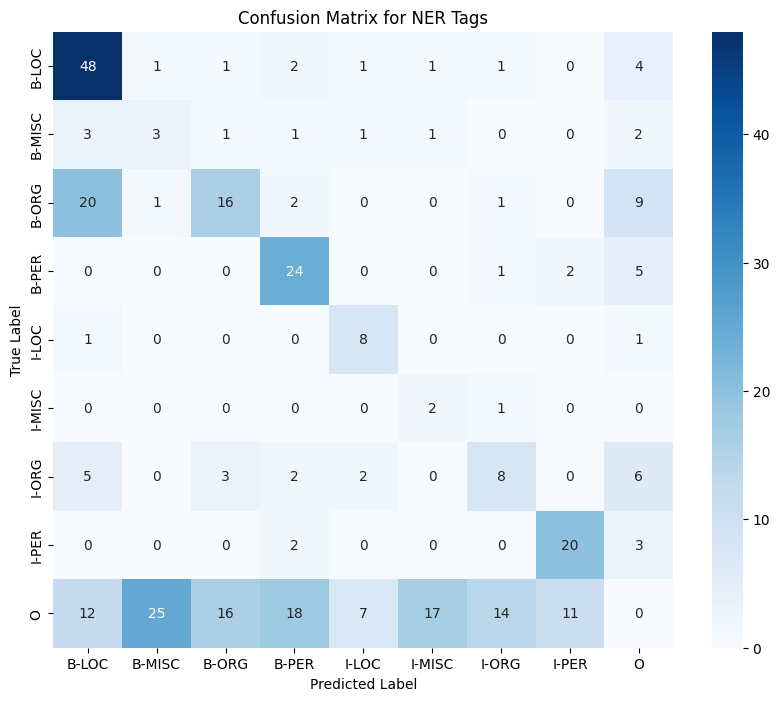

In [13]:
evaluate_predictions('data100_test_ds/vanilla_test_100_ds_14b.csv')
generate_ner_confusion_matrix_from_csv('data100_test_ds/vanilla_test_100_ds_14b.csv')

Invalid predictions: 6

Precision: 0.4427860696517413
Recall: 0.5894039735099338
F1 Score: 0.5056818181818182

Detailed classification report:

              precision    recall  f1-score   support

         LOC       0.54      0.76      0.63        58
        MISC       0.10      0.33      0.15        12
         ORG       0.49      0.39      0.43        49
         PER       0.55      0.69      0.61        32

   micro avg       0.44      0.59      0.51       151
   macro avg       0.42      0.54      0.46       151
weighted avg       0.49      0.59      0.52       151



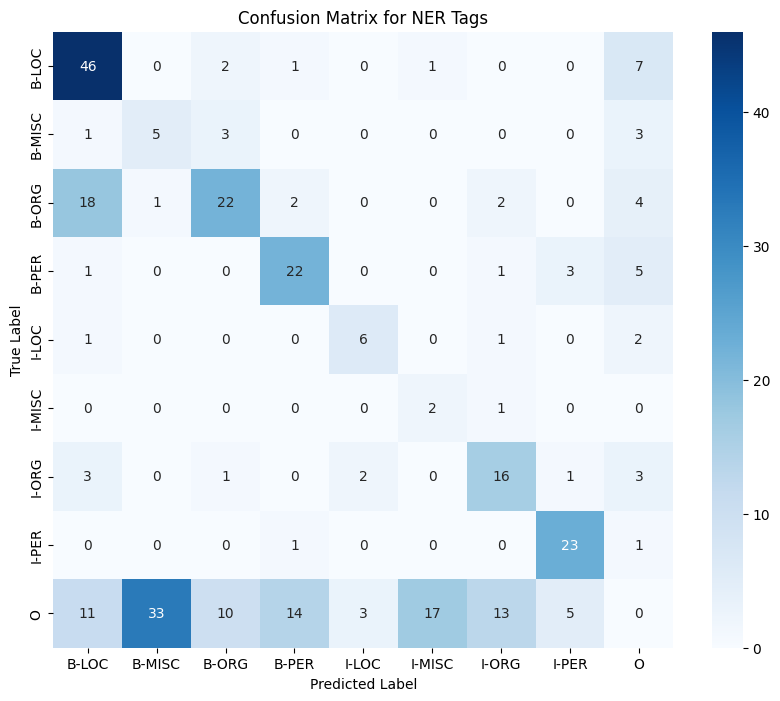

In [18]:
evaluate_predictions('data100_test_ds/vanilla_test_100_ds_14b_POSGNER.csv')
generate_ner_confusion_matrix_from_csv('data100_test_ds/vanilla_test_100_ds_14b_POSGNER.csv')

Invalid predictions: 0

Precision: 0.36
Recall: 0.47368421052631576
F1 Score: 0.40909090909090906

Detailed classification report:

              precision    recall  f1-score   support

         LOC       0.43      0.68      0.53        59
        MISC       0.18      0.42      0.25        12
         ORG       0.29      0.22      0.25        49
         PER       0.38      0.50      0.43        32

   micro avg       0.36      0.47      0.41       152
   macro avg       0.32      0.45      0.37       152
weighted avg       0.36      0.47      0.40       152



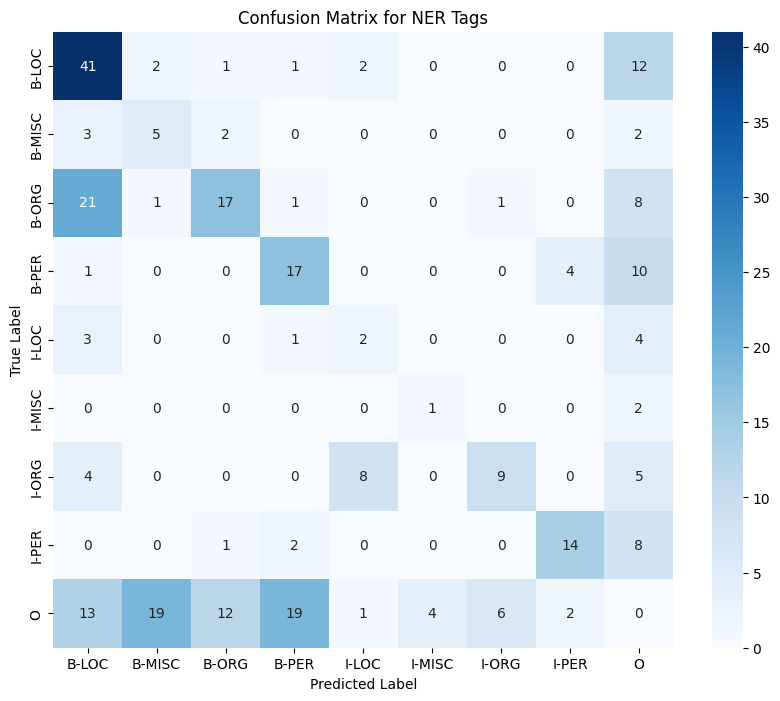

In [19]:
evaluate_predictions('data100_test_ds/vanilla_test_100_ds_14b_ADVANCED_NOBIO.csv')
generate_ner_confusion_matrix_from_csv('data100_test_ds/vanilla_test_100_ds_14b_ADVANCED_NOBIO.csv')

Invalid predictions: 0

Precision: 0.43523316062176165
Recall: 0.5526315789473685
F1 Score: 0.4869565217391304

Detailed classification report:

              precision    recall  f1-score   support

         LOC       0.46      0.69      0.55        59
        MISC       0.26      0.67      0.37        12
         ORG       0.41      0.33      0.36        49
         PER       0.56      0.59      0.58        32

   micro avg       0.44      0.55      0.49       152
   macro avg       0.42      0.57      0.47       152
weighted avg       0.45      0.55      0.48       152



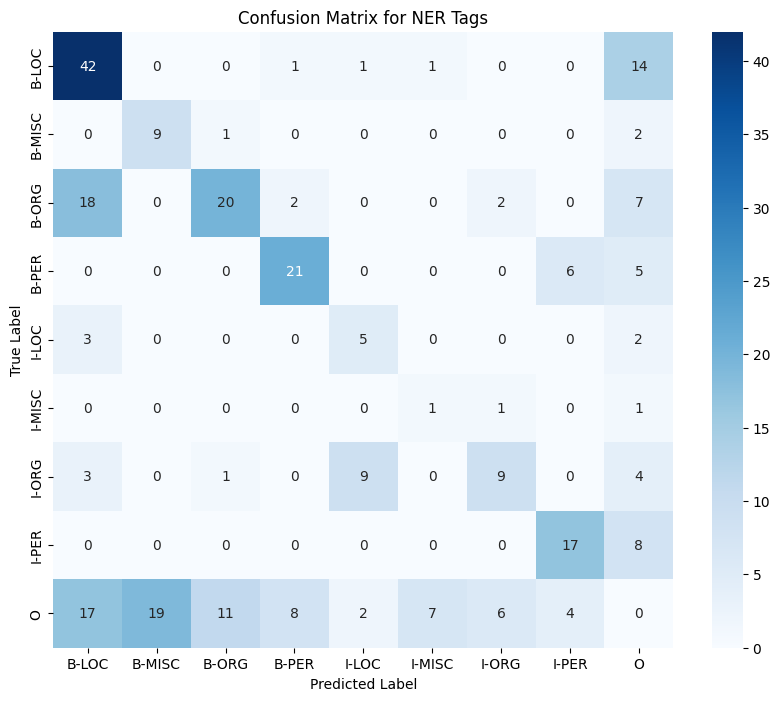

In [17]:
evaluate_predictions('data100_test_ds/vanilla_test_100_ds_14b_ADVANCEDPOS_NOBIO.csv')
generate_ner_confusion_matrix_from_csv('data100_test_ds/vanilla_test_100_ds_14b_ADVANCEDPOS_NOBIO.csv')

On the test set, the baseline (vanilla) method achieved an F1 score of **0.43**, with a precision of **0.37** and a recall of **0.52**. In contrast, our best method reached an F1 score of **0.49**, with a precision of **0.44** and a recall of **0.55**. This demonstrates a clear improvement in both precision and recall, resulting in a higher overall F1 score.

While the performance on the test set is slightly lower than on the training set (as expected due to the increased difficulty of generalization), the advanced prompt maintains a significant advantage over the baseline. This confirms that the improvements are not due to overfitting, but rather to a better modeling of the NER task.

## Gemma's Results
All the test were conducted using seed 0 and a sample of 100 elements from the test set.

The vanilla method on the test set showed that the base approach from the paper has low performance, achieving an F1 score of 0.33. In contrast, the vanilla method with BIO tagging performed significantly better, reaching an F1 score of 0.49, which is close to the performance of our best methods.

The POS-guided and context-aware prompts achieved slightly better results than the vanilla BIO method, with F1 scores of 0.51 and 0.50, respectively. Their combination yielded further improvement, reaching 0.53.

Finally, the Decomposed QA method delivered the best performance on the test set, achieving an F1 score of 0.56.

During the development and testing of these methods, we observed that the input data has a significant impact on model performance for the NER task. For example, during the training phase, the best prompt was the combination of the best prompts from both models and the overall performance of the methods were approximately 10% higher for all prompts.

In [ ]:
# Vanilla
evaluate_predictions('data_test_gemma/vanilla_bio.csv')
generate_ner_confusion_matrix_from_csv('data_test_gemma/vanilla_bio.csv')

In [ ]:
# Vanilla No BIO
evaluate_predictions('data_test_gemma/vanilla_no_bio.csv')
generate_ner_confusion_matrix_from_csv('data_test_gemma/vanilla_no_bio.csv')

In [ ]:
# Decomposed QA
evaluate_predictions('data_test_gemma/decomposed_qa.csv')
generate_ner_confusion_matrix_from_csv('data_test_gemma/decomposed_qa.csv')

In [ ]:
# Context Aware No BIO tagging Named Entity Recognition
evaluate_predictions('data_test_gemma/context_aware.csv')
generate_ner_confusion_matrix_from_csv('data_test_gemma/context_aware.csv')

In [ ]:
# POSGNER No BIO
evaluate_predictions('data_test_gemma/pos_guided_no_bio.csv')
generate_ner_confusion_matrix_from_csv('data_test_gemma/pos_guided_no_bio.csv')

In [ ]:
# POSGNER BIO
evaluate_predictions('data_test_gemma/pos_guided_bio.csv')
generate_ner_confusion_matrix_from_csv('data_test_gemma/pos_guided_bio.csv')

In [ ]:
# Combination
evaluate_predictions('data_test_gemma/combination.csv')
generate_ner_confusion_matrix_from_csv('data_test_gemma/combination.csv')

# Conclusions


The experiments conducted in this project highlight the crucial role of prompt engineering and model selection in zero/few-shot Named Entity Recognition (NER) tasks. Our results show that carefully designed prompts, especially those that incorporate linguistic information such as POS tags and clear task instructions, consistently improve the quality of entity recognition.

It is also evident that the choice of language model has a significant impact on performance. Different models respond differently to the same prompts: some benefit more from additional syntactic information or decomposed tasks, while others may perform better with concise, context-focused instructions. This variability suggests that there is no universally optimal prompt, but rather that prompt effectiveness depends on the specific characteristics and capabilities of the underlying model.

It should also be noted that the datasets used for both training and evaluation were relatively limited in size. This constraint may have influenced the observed results and the generalization ability of the models. If a larger dataset had been used, the performance metrics and the relative effectiveness of different prompts and models could potentially vary, possibly revealing new strengths or weaknesses not captured in our current experiments.

These findings confirm that both prompt design and model architecture must be considered together to maximize NER performance. Investing effort in prompt engineering and leveraging the strengths of each model can yield substantial improvements, even in zero-shot or few-shot scenarios.